## Topic modelling for AI guidelines of newsrooms

In [1]:
#set up
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Guidelines_texts.csv', skipfooter=6)

df_full_text = df.dropna(subset=['Text'])

C:\Users\shrim\AppData\Local\Temp/ipykernel_9784/2378812823.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('Guidelines_texts.csv', skipfooter=6)


### Text preprocessing

The following script makes use of SpaCy for multiple text pre-processing steps, including:

1. NA dropping
2. Tokenization
3. Stop word removal

In [2]:
import spacy

#loading english model
sp_en = spacy.load('en_core_web_sm')

In [3]:
#Increase module max length for processing
sp_en.max_length = 2000000

#joining tokens to corpus creation
doc = sp_en(''.join(str(df_full_text['Text'].tolist())))

In [4]:
#Tokenzing all
from spacy.lang.en.stop_words import STOP_WORDS
import re

# #create stopwords for the pipeline
# extra_stopwords = {'GENEVA','BEIJING','MOSCOW','WASHINGTON','NEW','DELHI','YORK', 'CAIRO', 'BRUSSELS', 'CANBERRA', 'ROME',}
base_stopwords = sp_en.Defaults.stop_words
# base_stopwords.remove('not')
# base_stopwords.remove("no")
# base_stopwords.remove("n‘t")
# base_stopwords.remove("n’t")

#Append tokens to pandas dataframe 
tokening = []
for text in sp_en.pipe(df_full_text['Text']):
   tokenizer = [token.lemma_ for token in text if token.pos_ not in base_stopwords and token.text
               and not token.is_stop and token.is_alpha and not token.is_punct]
   tokening.append(tokenizer)

df_full_text['tokens'] = tokening

df_full_text['clean_text'] = df_full_text.apply(lambda x: ' '.join(x['tokens']), 
                                                axis = 1)

C:\Users\shrim\AppData\Local\Temp/ipykernel_9784/3624437474.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_text['tokens'] = tokening
C:\Users\shrim\AppData\Local\Temp/ipykernel_9784/3624437474.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_text['clean_text'] = df_full_text.apply(lambda x: ' '.join(x['tokens']),


### Named Entity Recognition
We use SpaCy's built-in module of NER to recognise three entity groups of interest, namely location and organization. NORP was included in the script but was not used as a part of the analysis.

### Topic modelling

For this project, we are going to gensim to conduct our topic modelling. We will use the LDA module to cluster topic key words for body texts and NMF for headlines. In addition, the main corpora will be split into two sets: (1) a full corpus and (2) a noun-only corpus.

For coherence modelling, we will use u_mass and c_v as our coherence measures.

In [5]:
#Topic modelling: LDA full corpus
import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary

#Dictionary creation
dictionary = corpora.Dictionary(df_full_text['tokens'])

#Remove low freq tokens
dictionary.filter_extremes(no_below=10, keep_n=None)

#Corpus creation: List tokens freq with id 
corpus = [dictionary.doc2bow(doc) for doc in df_full_text['tokens']]

In [6]:
#Construct test LDA model: Full corpus
from gensim.models import LdaMulticore

lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, 
                         num_topics=15, workers = 6, passes=10, chunksize = 50)

In [7]:
#Tokenzing only noun
tokening_nounonly = []

for text in sp_en.pipe(df_full_text['Text']):
            tokenizer = [token.lemma_ for token in text if token.pos_ == "NOUN" or token.pos_ == "PROPN" and 
                         token.pos_ not in base_stopwords and token.text 
                         and not token.is_stop and token.is_alpha and not token.is_punct]
            tokening_nounonly.append(tokenizer)
    
df_full_text['tokens_noun'] = tokening_nounonly

C:\Users\shrim\AppData\Local\Temp/ipykernel_9784/1665977412.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_text['tokens_noun'] = tokening_nounonly


In [8]:
#Topic modelling: LDA only noun

#Dictionary creation
dictionary_nounonly = corpora.Dictionary(df_full_text['tokens_noun'])

#Remove low freq tokens
dictionary_nounonly.filter_extremes(no_below=5, keep_n=None)

#Corpus creation: List tokens freq with id 
corpus_nounonly = [dictionary.doc2bow(doc) for doc in df_full_text['tokens_noun']]

In [9]:
#Construct LDA model: Noun only corpus
lda_model_noun = gensim.models.LdaMulticore(corpus=corpus_nounonly,id2word=dictionary_nounonly,
                                            num_topics=15,workers=6, passes=10, chunksize=50)

In [10]:
#Model evaluation: Full corpus
from gensim.models import CoherenceModel

candidate_topics = []
c_score = []

#using C_v measure
for i in range(1,15,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, 
                         num_topics=i, workers = 6, passes=10)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='c_v', 
                      texts = df_full_text['tokens'])
    
    candidate_topics.append(i)
    c_score.append(cm.get_coherence())

In [11]:
#using UMass (score based on document co-occurence)
candidate_topics_umass = []
c_score_umass = []

for i in range(1,15,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, 
                         num_topics=i, workers = 6, passes=10)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    
    candidate_topics_umass.append(i)
    c_score_umass.append(cm.get_coherence())

In [12]:
#Model evaluation: Noun only using cv
candidate_topics_noun_cv = []
c_score_noun_cv = []

#using C_v measure
for i in range(1,15,1):
    lda_model = LdaMulticore(corpus=corpus_nounonly, id2word=dictionary_nounonly, iterations=50, 
                         num_topics=i, workers = 6, passes=10)
    cm = CoherenceModel(model=lda_model, corpus=corpus_nounonly, dictionary=dictionary_nounonly, coherence='c_v', 
                      texts = df_full_text['tokens_noun'])
    
    candidate_topics_noun_cv.append(i)
    c_score_noun_cv.append(cm.get_coherence())

In [13]:
#using UMass (score based on document co-occurence)
candidate_topics_noun_umass = []
c_score_noun_umass = []

for i in range(1,15,1):
    lda_model = LdaMulticore(corpus=corpus_nounonly, id2word=dictionary_nounonly, iterations=50, 
                         num_topics=i, workers = 6, passes=10)
    cm = CoherenceModel(model=lda_model, corpus=corpus_nounonly, dictionary=dictionary_nounonly, coherence='u_mass')
    
    candidate_topics_noun_umass.append(i)
    c_score_noun_umass.append(cm.get_coherence())

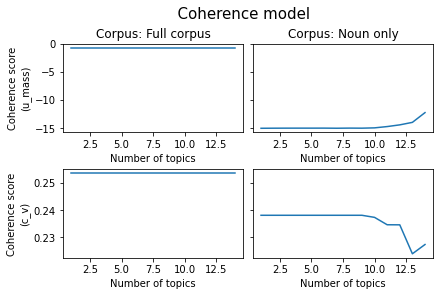

<Figure size 1440x8280 with 0 Axes>

In [51]:
#plotting coherence model


fig, axs = plt.subplots(2, 2, constrained_layout=True, sharey='row')

fig.suptitle('          Coherence model', fontsize=15)

axs[0, 0].plot(candidate_topics_umass, c_score_umass)
axs[0, 0].set_title('Corpus: Full corpus')
axs[0, 0].set_xlabel('Number of topics')
axs[0, 0].set_ylabel('Coherence score\n(u_mass)')

axs[0, 1].plot(candidate_topics_noun_umass, c_score_noun_umass)
axs[0, 1].set_title('Corpus: Noun only')
axs[0, 1].set_xlabel('Number of topics')

axs[1, 0].plot(candidate_topics, c_score)
axs[1, 0].set_xlabel('Number of topics')
axs[1, 0].set_ylabel('Coherence score\n(c_v)')

axs[1, 1].plot(candidate_topics_noun_cv, c_score_noun_cv)
axs[1, 1].set_xlabel('Number of topics')

plt.figure(figsize=(20,115))
plt.show()



In [23]:
#Optimised model: Noun corpus
lda_model = LdaMulticore(corpus=corpus_nounonly, id2word=dictionary_nounonly, iterations=50, 
                         num_topics=7, workers = 6, passes=10, chunksize = 50)

In [24]:
#Print topics of full corpus
lda_model.print_topics()

[(0,
  '0.497*"case" + 0.095*"bias" + 0.095*"context" + 0.004*"guideline" + 0.004*"idea" + 0.004*"feedback" + 0.004*"development" + 0.004*"decision" + 0.004*"generation" + 0.004*"application"'),
 (1,
  '0.014*"decision" + 0.014*"bias" + 0.013*"context" + 0.013*"feedback" + 0.013*"development" + 0.013*"case" + 0.013*"idea" + 0.013*"generation" + 0.013*"guideline" + 0.013*"application"'),
 (2,
  '0.494*"context" + 0.083*"idea" + 0.047*"decision" + 0.022*"guideline" + 0.013*"feedback" + 0.006*"development" + 0.005*"bias" + 0.005*"case" + 0.005*"generation" + 0.005*"application"'),
 (3,
  '0.041*"development" + 0.019*"feedback" + 0.014*"idea" + 0.013*"guideline" + 0.013*"decision" + 0.013*"bias" + 0.013*"context" + 0.013*"case" + 0.013*"generation" + 0.013*"application"'),
 (4,
  '0.549*"development" + 0.125*"decision" + 0.056*"case" + 0.052*"generation" + 0.039*"bias" + 0.007*"context" + 0.002*"application" + 0.002*"feedback" + 0.002*"idea" + 0.002*"guideline"'),
 (5,
  '0.199*"bias" + 0.

In [25]:
#topic viz: Full corpus
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_nounonly, dictionary_nounonly)

pyLDAvis.save_html(lda_display, 'Topic model.html')

In [26]:
#Grouping topics
document_topic = []
first_topic = []

#Get topics of each article
for i in range(len(corpus)):
    topic_id = lda_model.get_document_topics(corpus_nounonly[i], 0.4)
    document_topic.append(topic_id)
    
#Get topic id with highest score of each article
for i in range(len(corpus_nounonly)):
    try:
        topic_id = max(document_topic[i])[0] 
        first_topic.append(topic_id)
    except IndexError: 
            topic_id = 'NA'
            first_topic.append(topic_id)
    except ValueError: #append NA if empty list is passed
            topic_id = 'NA'
            first_topic.append(topic_id) 

df_full_text['topic_id'] = first_topic

C:\Users\shrim\AppData\Local\Temp/ipykernel_9784/3873767656.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_text['topic_id'] = first_topic
